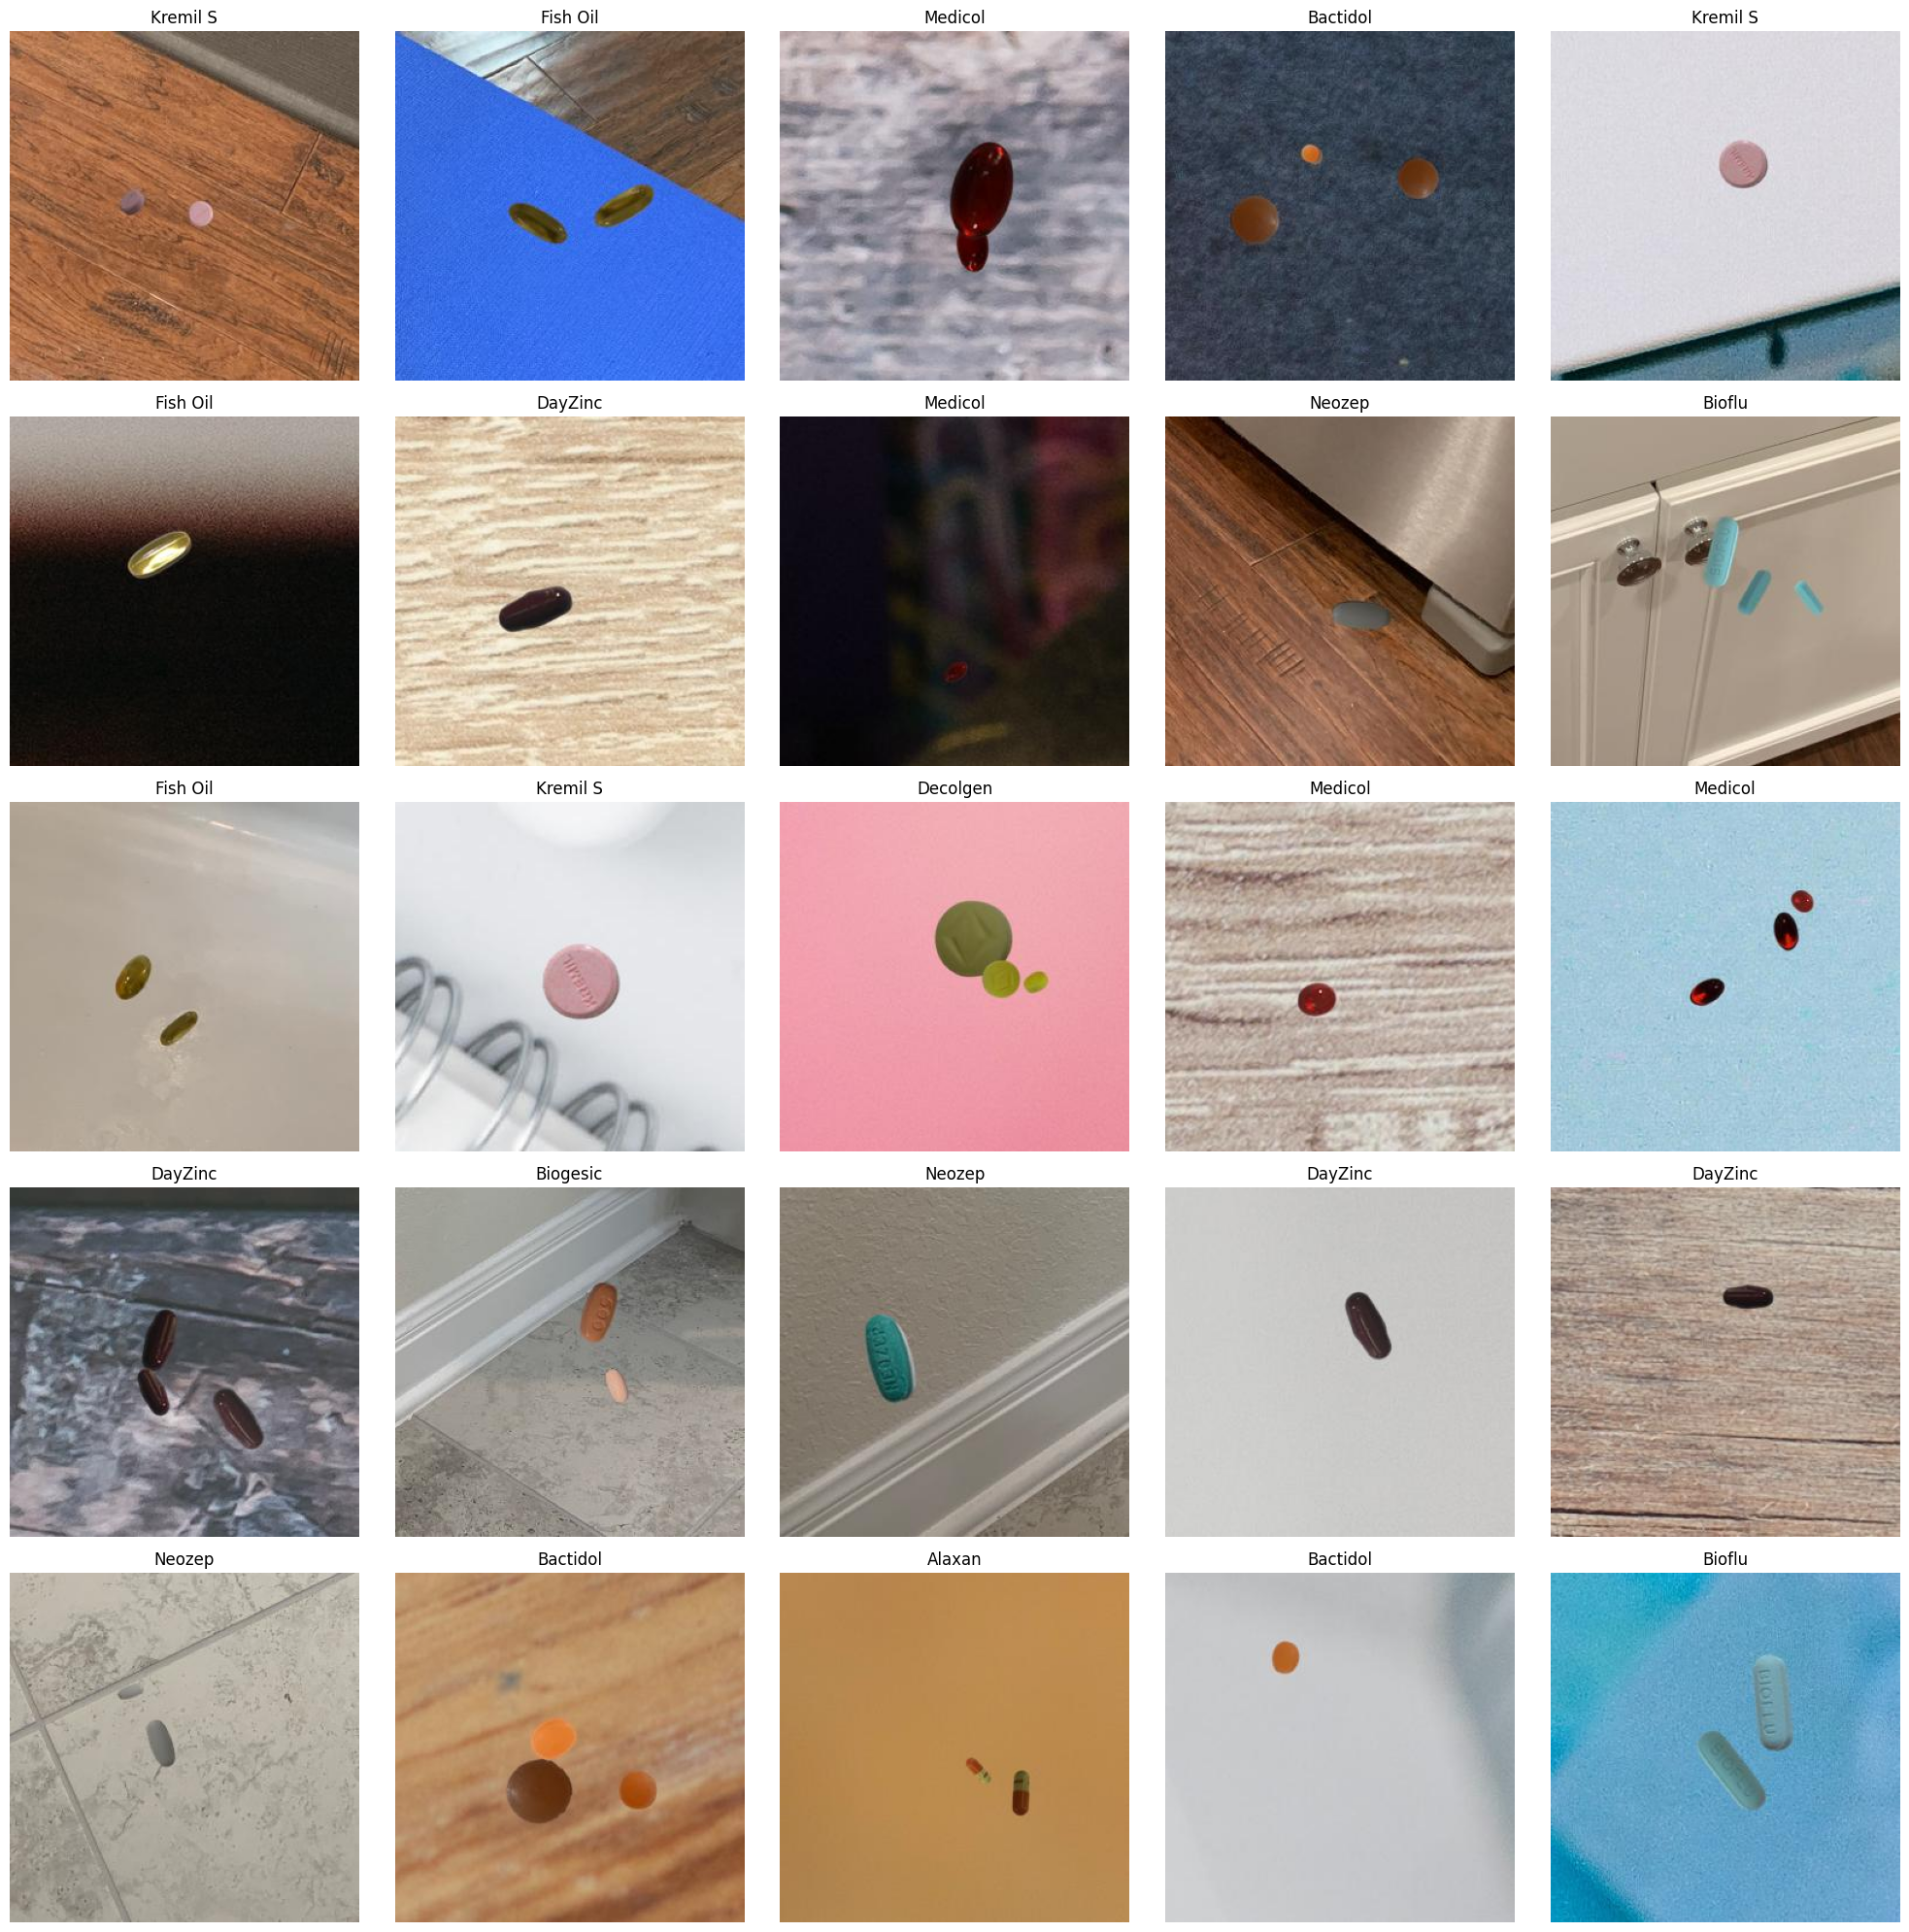

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf 
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.layers import Rescaling , Resizing  # preprocessing layers kullanılmadıgı için farklı sekilde import edilmistir

from tensorflow.keras.applications import MobileNetV2

from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

dataset = "Drug Vision/Data Combined"
image_dir  = Path(dataset)

filepaths = list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

random_index = np.random.randint(0, len(image_df), 25)
fig, ax = plt.subplots(5, 5, figsize=(20, 20))
for i, ax in enumerate(ax.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
    ax.axis('off')
plt.tight_layout()

In [2]:
image_df.columns

Index(['Filepath', 'Label'], dtype='object')

In [3]:
train_df , test_df = train_test_split(image_df, test_size=0.2, shuffle=True)

train_generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split = 0.2)

test_generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split = 0.2)

train_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'Filepath', # goruntu yolu
    y_col = 'Label', # etiket
    target_size = (224, 224), # goruntunun boyutu
    color_mode = 'rgb', # renkli goruntu
    class_mode = 'categorical', # cok sinifli siniflandirma
    batch_size = 64,
    shuffle=True, # rastgele
    seed = 42,
    subset = 'training' 
)


validation_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 64
)

test_images = test_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 64
)

resize_and_rescale = tf.keras.Sequential(
    [
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.Rescaling(1.0/255)]
)

Found 6125 validated image filenames belonging to 10 classes.
Found 7656 validated image filenames belonging to 10 classes.
Found 1914 validated image filenames belonging to 10 classes.


In [4]:
pretrainded_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top = False, # mobile net sınıflandırma katmanıı dahil etme
    weights = 'imagenet', # hangi veri setiyle egitildigi
    pooling = 'avg'
)
pretrainded_model.trainable = False

# callbacks
ck_path = "pharmaceutical_drugs_and_vitamins_classification_model_checkpoint.weights.h5"
ck_call = ModelCheckpoint(ck_path, save_weights_only=True, monitor="val_accuracy", save_best_only=True)

early_stop = EarlyStopping(monitor = "val_accuracy", patience = 3,restore_best_weights=True)

# build
inputs = pretrainded_model.input
x = pretrainded_model.output
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs = inputs, outputs = outputs)

model.compile(optimizer = Adam(0.0001), loss = "categorical_crossentropy", metrics = ["accuracy"])

history = model.fit(train_images,steps_per_epoch = len(train_images),validation_data = validation_images,validation_steps = len(validation_images),epochs = 5,callbacks = [early_stop, ck_call])

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 296s 3s/step - accuracy: 0.2058 - loss: 2.2363 - val_accuracy: 0.6160 - val_loss: 1.3546
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 285s 3s/step - accuracy: 0.5534 - loss: 1.3601 - val_accuracy: 0.7513 - val_loss: 0.8782
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - accuracy: 0.6727 - loss: 1.0038 - val_accuracy: 0.7998 - val_loss: 0.6862
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 268s 3s/step - accuracy: 0.7212 - loss: 0.8157 - val_accuracy: 0.8191 - val_loss: 0.5812
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.7556 - loss: 0.7157 - val_accuracy: 0.8391 - val_loss: 0.5104


In [6]:
loss, accuracy = model.evaluate(test_images, verbose = 1)
print(f"loss : {loss}")
print(f"accuracy : {accuracy}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8093 - loss: 0.6007
loss : 0.5937883853912354
accuracy : 0.8061650991439819


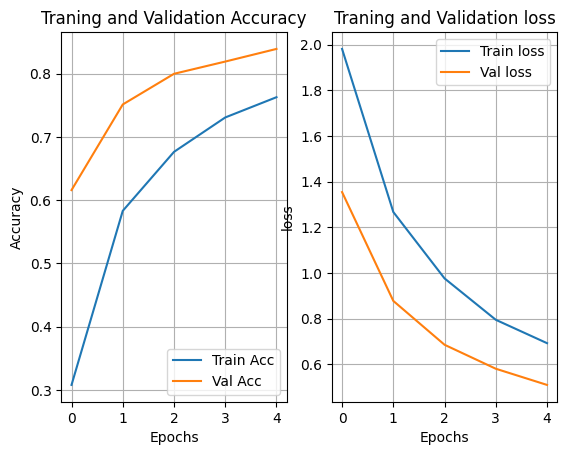

In [7]:
plt.figure()

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Traning and Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid('True')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title("Traning and Validation loss")
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.grid('True')

30/30 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step


IndexError: single positional indexer is out-of-bounds

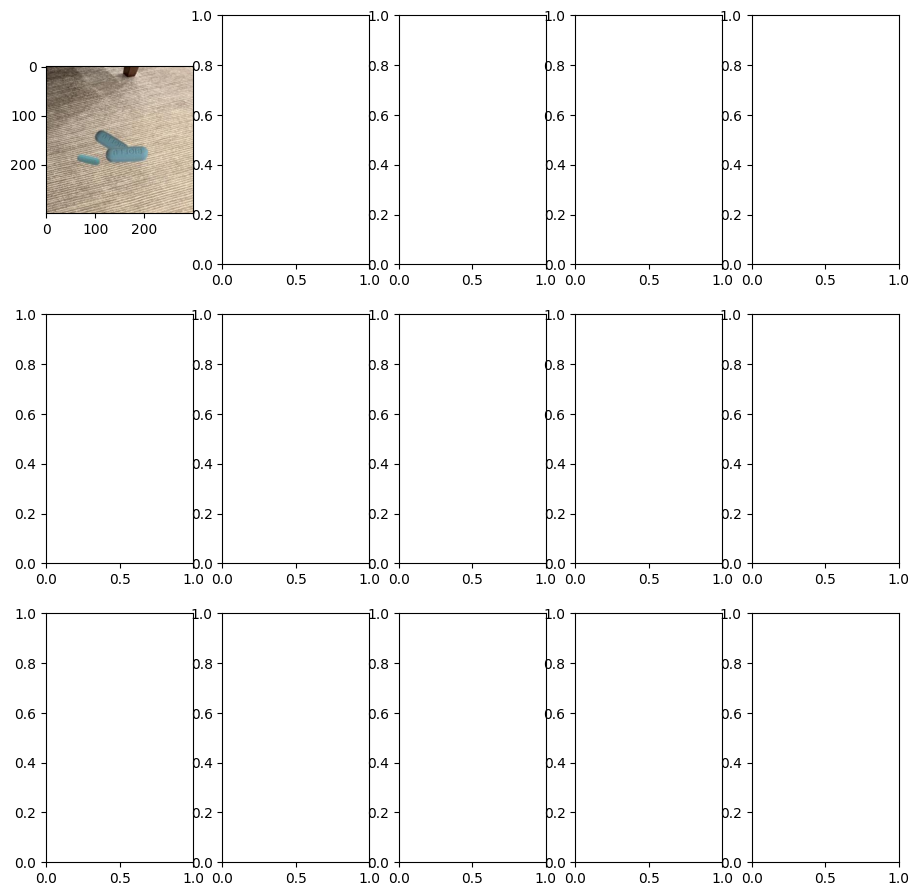

In [15]:
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())

pred = [labels[k] for k in pred]

random_index = np.random.choice(test_df.index, 15, replace=False)
fig, ax = plt.subplots(3, 5, figsize=(11, 11))

for i, ax in enumerate(ax.flat):
    ax.imshow(plt.imread(test_df.Filepath[random_index[i]]))
    true_label = test_df.Label.iloc[random_index[i]]
    pred_label = pred[random_index[i]]
    if true_label == pred_label:
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", color='green')
    else:
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", color='red')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [16]:
print(classification_report(test_df.Label, pred))

              precision    recall  f1-score   support

      Alaxan       0.06      0.04      0.05       115
    Bactidol       0.09      0.09      0.09       196
      Bioflu       0.08      0.10      0.09       192
    Biogesic       0.09      0.11      0.10       181
     DayZinc       0.08      0.08      0.08       209
    Decolgen       0.09      0.09      0.09       209
    Fish Oil       0.17      0.18      0.17       205
    Kremil S       0.10      0.09      0.10       212
     Medicol       0.12      0.12      0.12       194
      Neozep       0.10      0.08      0.09       201

    accuracy                           0.10      1914
   macro avg       0.10      0.10      0.10      1914
weighted avg       0.10      0.10      0.10      1914

